In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

Daten laden

In [3]:
#script_dir = os.path.dirname(os.path.abspath(__file__))
#file_path = os.path.join(script_dir, '../0_DataPreparation/merged_data_full_with_weekdays.csv')
training_data = pd.read_csv('../0_DataPreparation/merged_data_full_with_weekdays.csv')
training_data['Datum'] = pd.to_datetime(training_data['Datum'])


Feature Engineering

In [4]:
training_data['Jahr'] = training_data['Datum'].dt.year
training_data['Monat'] = training_data['Datum'].dt.month
training_data['Wochentag'] = training_data['Datum'].dt.dayofweek

Kategorische und numerische Features vorbereiten

In [5]:
kategorische_features = ['Warengruppe', 'Feiertag']
numerische_features = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'KielerWoche', 
                       'Jahr', 'Monat', 'Wochentag']

Preprocessor für kategorische und numerische Daten

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerische_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', sparse_output=False))
        ]), kategorische_features),
    ]
)

Pipeline für Gradient Boosting

In [7]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor())
])

Vorbereitung der Features und Zielvariable

In [8]:
X = training_data[kategorische_features + numerische_features]
y = training_data['Umsatz']

Model fitten

In [9]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Temperatur',
                                                   'Windgeschwindigkeit',
                                                   'Bewoelkung', 'KielerWoche',
                                                   'Jahr', 'Monat',
                                                   'Wochentag']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Warengruppe',
                                                   'Feiertag'])])),
                ('regressor', HistGradientBoostingRegressor())])

Vorhersagen und R² berechnen

In [10]:
y_pred = pipeline.predict(X)
r2 = r2_score(y, y_pred)

Adjusted R² berechnen

In [11]:
n = X.shape[0]  # Anzahl der Beobachtungen
p = X.shape[1]  # Anzahl der Prädiktoren
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R²: {r2:.4f}")
print(f"Adjustiertes R²: {adjusted_r2:.4f}")

R²: 0.9001
Adjustiertes R²: 0.9000


Plotten

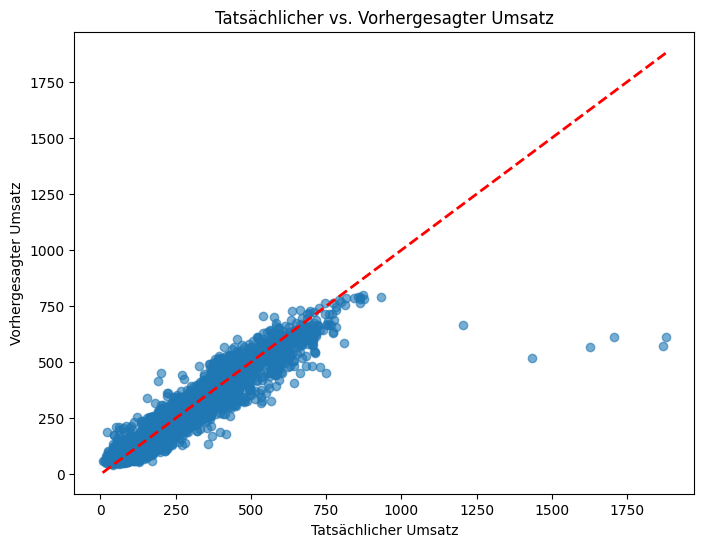

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Tatsächlicher Umsatz')
plt.ylabel('Vorhergesagter Umsatz')
plt.title('Tatsächlicher vs. Vorhergesagter Umsatz')
plt.show()